In [1]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASET = "/kaggle/input/densenet50finaldata/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


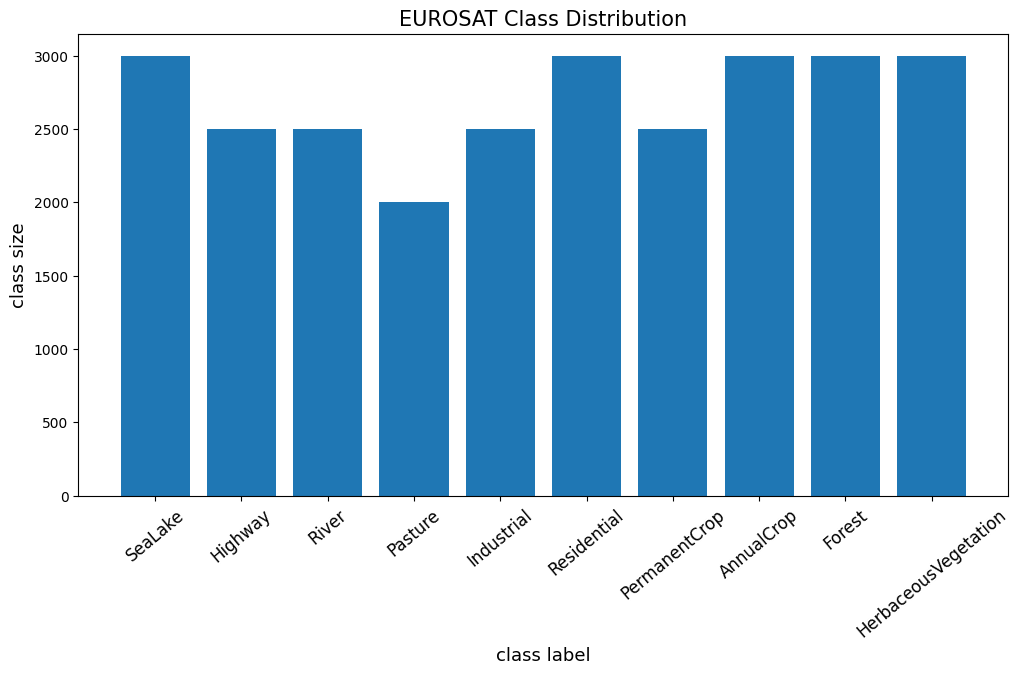

In [3]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [ ]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [5]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/kaggle/working/training'
TEST_DIR = '/kaggle/working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

2024-03-10 05:42:27.069701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 05:42:27.069851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 05:42:27.229667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import os
import re
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

DATASET = '/kaggle/input/densenet50finaldata/2750'
TRAIN_DIR = '/kaggle/working/training'
TEST_DIR = '/kaggle/working/testing'
LABELS = os.listdir(DATASET)  # Assuming each subdirectory in DATASET corresponds to a class

# Map each image path to its class label in 'data'
data = {}
for l in LABELS:
    for img in os.listdir(os.path.join(DATASET, l)):
        data[os.path.join(DATASET, l, img)] = l

# Convert the mapping to pandas Series
X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

# Perform stratified split
train_paths, test_paths, _, _ = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)

# Define new paths for training and testing
new_train_paths = [re.sub(DATASET, TRAIN_DIR, path) for path in train_paths]
new_test_paths = [re.sub(DATASET, TEST_DIR, path) for path in test_paths]

# Move files to training directory
print("Moving training files...")
for source, destination in tqdm(zip(train_paths, new_train_paths)):
    if not os.path.exists(destination):
        shutil.copy(source, destination)

# Move files to testing directory
print("Moving testing files...")
for source, destination in tqdm(zip(test_paths, new_test_paths)):
    if not os.path.exists(destination):
        shutil.copy(source, destination)

Moving training files...


21600it [01:14, 289.11it/s]


Moving testing files...


5400it [00:17, 301.71it/s]


In [7]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    #color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [8]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [9]:
np.save('class_indices', train_generator.class_indices)

In [10]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [11]:
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    if cnn_base == 'DenseNet121':
        conv_base = DenseNet121(include_top=False,
                                weights=None,  # Change to None since we'll load weights manually
                                input_shape=input_shape)
        top_model = conv_base.output
        top_model = GlobalAveragePooling2D()(top_model)
        top_model = Dense(2048, activation=tf.keras.activations.gelu)(top_model)
        top_model = Dropout(0.2)(top_model)

    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    return model

In [12]:
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

In [13]:
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat


In [14]:
def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [15]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 2

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.best.keras',
                              monitor='val_categorical_accuracy',
                              save_best_only=True,
                              verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [16]:
denseNet121_model = compile_model('DenseNet121', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)
#denseNet121_model.summary()

In [17]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 2

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.best.keras',
                              monitor='val_categorical_accuracy',
                              save_best_only=True,
                              verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [18]:
denseNet121_history = denseNet121_model.fit(train_generator,
                                      steps_per_epoch=N_STEPS,
                                      epochs=2,
                                      callbacks=[early_stop, checkpoint],
                                      validation_data=test_generator,
                                      validation_steps=N_VAL_STEPS)

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - categorical_accuracy: 0.2965 - loss: 1.8250
Epoch 1: val_categorical_accuracy improved from -inf to 0.43359, saving model to ../working/model.best.keras
337/337 ━━━━━━━━━━━━━━━━━━━━ 213s 579ms/step - categorical_accuracy: 0.2967 - loss: 1.8244 - val_categorical_accuracy: 0.4336 - val_loss: 1.4299
Epoch 2/2
  1/337 ━━━━━━━━━━━━━━━━━━━━ 2:14 400ms/step - categorical_accuracy: 0.4375 - loss: 1.4192

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_categorical_accuracy improved from 0.43359 to 0.66667, saving model to ../working/model.best.keras
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - categorical_accuracy: 0.4375 - loss: 0.7117 - val_categorical_accuracy: 0.6667 - val_loss: 0.5450


In [19]:
denseNet121_model = compile_model('DenseNet121', INPUT_SHAPE, NUM_CLASSES, Adam(learning_rate=1e-2), fine_tune=None)

denseNet121_model.load_weights('../working/model.best.keras')

train_generator.reset()
test_generator.reset()

denseNet121_model = denseNet121_model.fit(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - categorical_accuracy: 0.4424 - loss: 1.4762
Epoch 1: val_categorical_accuracy did not improve from 0.66667
337/337 ━━━━━━━━━━━━━━━━━━━━ 207s 564ms/step - categorical_accuracy: 0.4425 - loss: 1.4759 - val_categorical_accuracy: 0.4970 - val_loss: 1.4585 - learning_rate: 0.0100
Epoch 2/2
  1/337 ━━━━━━━━━━━━━━━━━━━━ 2:17 409ms/step - categorical_accuracy: 0.5625 - loss: 1.2869
Epoch 2: val_categorical_accuracy did not improve from 0.66667
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.5625 - loss: 0.6454 - val_categorical_accuracy: 0.5417 - val_loss: 0.9742 - learning_rate: 0.0100


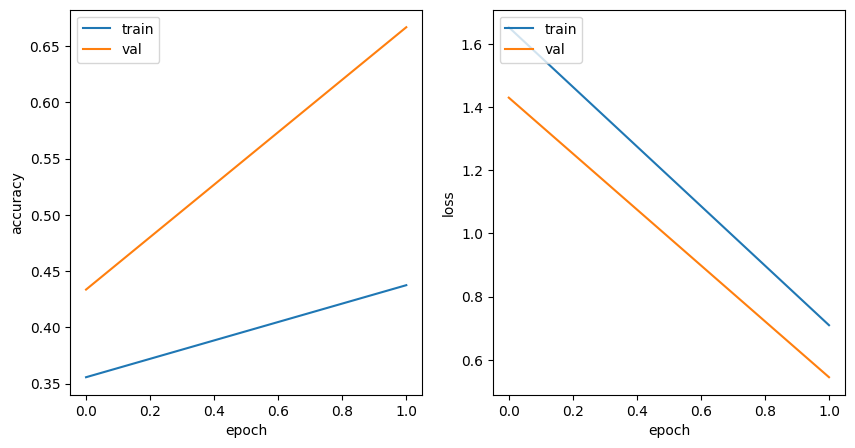

In [20]:
plot_history(denseNet121_history)

In [21]:
from keras.models import load_model

# Load the entire model (architecture and weights)
denseNet121_model = load_model('../working/model.best.keras')

class_indices = train_generator.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

# Use the predict method directly instead of predict_generator
predictions = denseNet121_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf


Found 5400 images belonging to 10 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 734 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


5400/5400 ━━━━━━━━━━━━━━━━━━━━ 154s 28ms/step
Accuracy: 0.3225925925925926
Global F2 Score: 0.3225925925925926


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
AnnualCrop,0.105524,0.496667,0.174065,600.0
Forest,0.949580,0.188333,0.314325,600.0
HerbaceousVegetation,1.000000,0.018333,0.036007,600.0
Highway,0.000000,0.000000,0.000000,500.0
Industrial,0.879195,0.786000,0.829989,500.0
Pasture,0.000000,0.000000,0.000000,400.0
PermanentCrop,0.305970,0.410000,0.350427,500.0
Residential,0.520971,0.786667,0.626826,600.0
River,0.000000,0.000000,0.000000,500.0
SeaLake,0.673854,0.416667,0.514933,600.0


In [22]:
#denseNet121_model.save('/kaggle/working/models/Densenet121_eurosat.h5')


In [26]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import numpy as np
import os

# Define the path to your new_test_image folder
new_test_image_folder = '/kaggle/input/tirupatidataset'

# Define the image size
img_size = (64, 64)

# Function to load and preprocess each image
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=img_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.  # normalize pixel values to [0, 1]
    return img

# Load and preprocess each image in the new_test_image folder
new_test_images = []
for image_file in os.listdir(new_test_image_folder):
    image_path = os.path.join(new_test_image_folder, image_file)
    img = load_and_preprocess_image(image_path)
    new_test_images.append(img)

new_test_images = np.vstack(new_test_images)  # stack images

# Load the trained model
model = load_model('../working/model.best.keras')

# Predict the classes of the new images
predictions = model.predict(new_test_images)
predicted_classes = np.argmax(predictions, axis=1)

print(len(new_test_images))
print(predicted_classes)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step
64
[2 1 6 1 2 2 2 7 2 7 2 2 1 1 6 1 1 2 1 1 2 7 2 1 2 1 7 2 1 2 2 7 6 1 1 6 1
 6 2 6 1 2 2 2 1 2 2 2 2 6 1 1 6 2 2 7 1 7 1 2 6 1 2 6]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


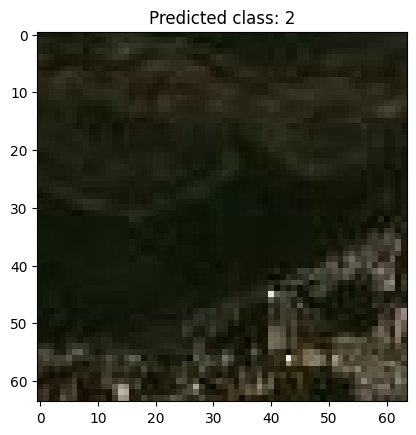

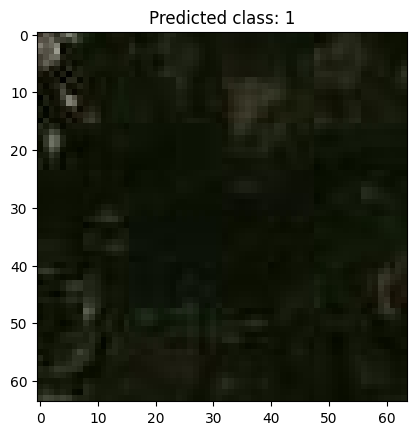

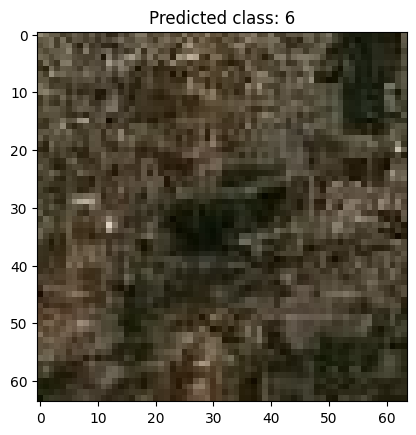

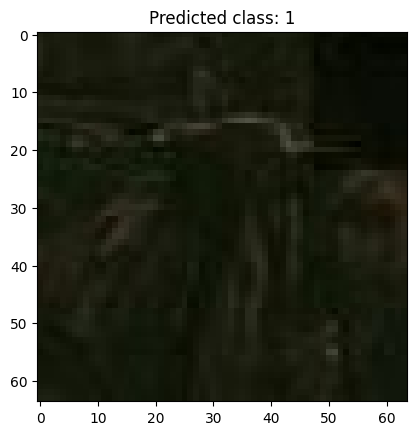

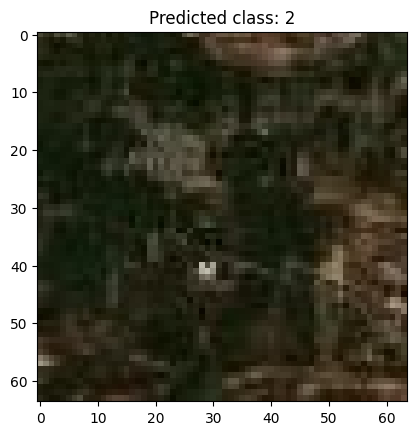

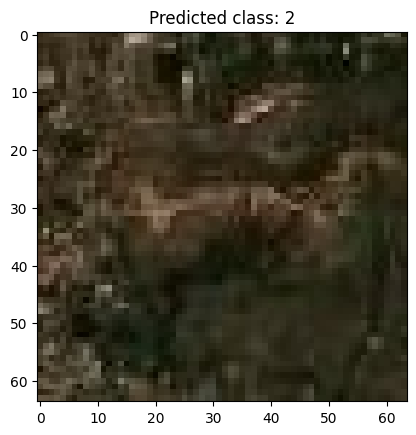

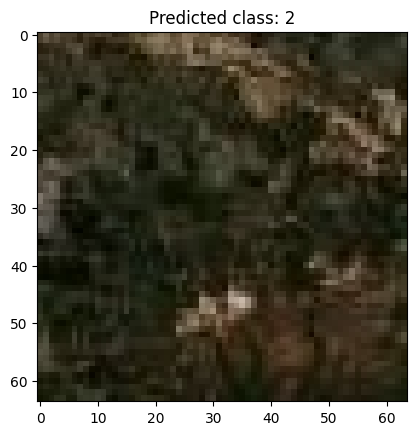

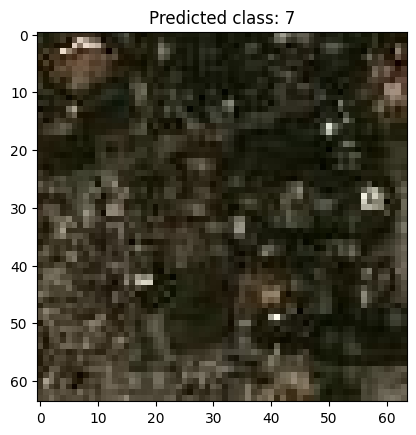

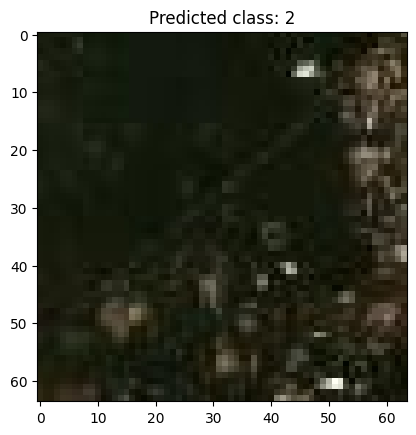

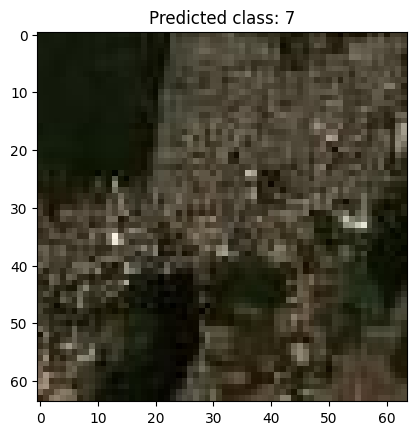

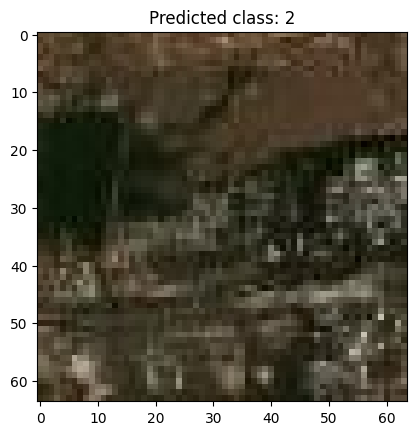

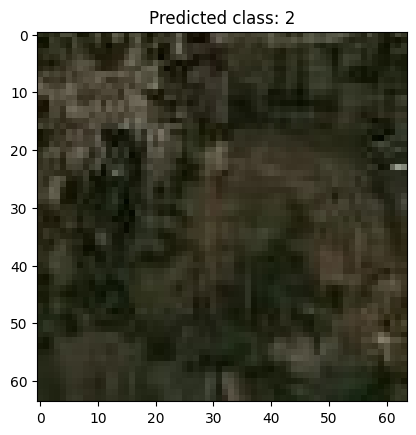

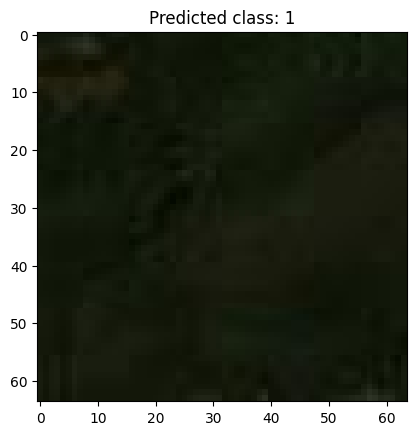

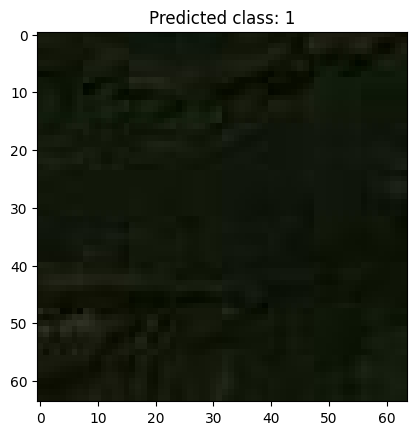

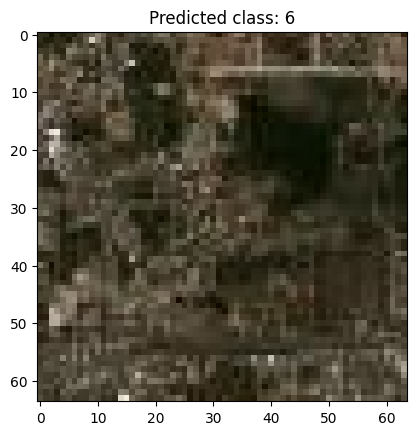

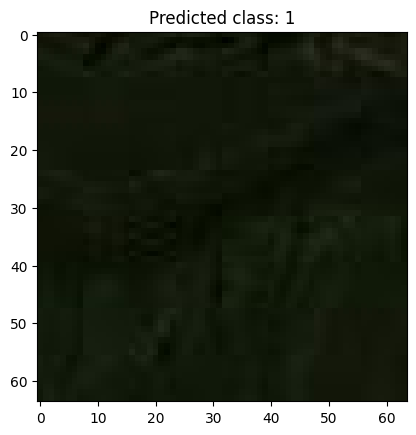

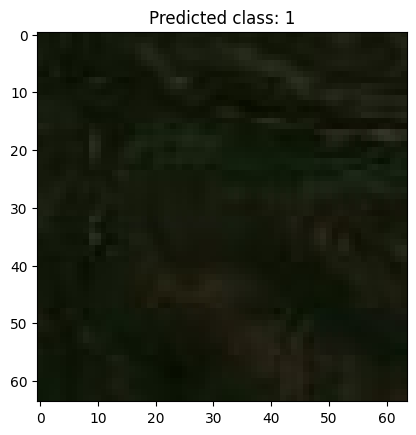

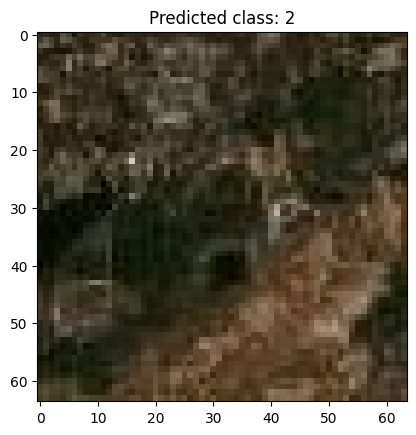

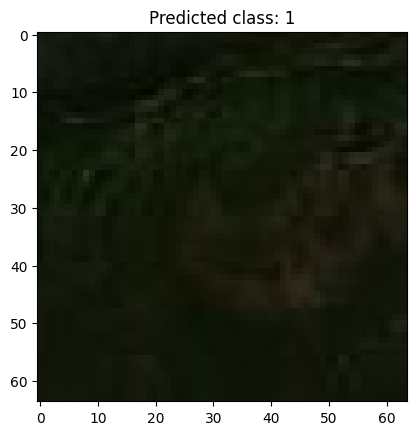

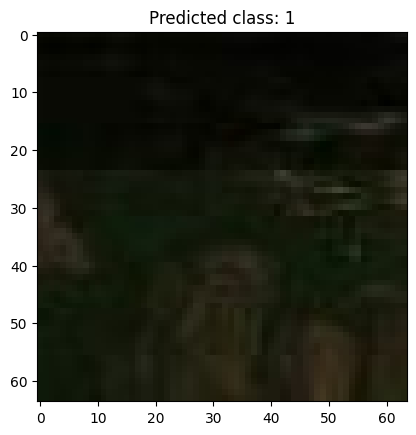

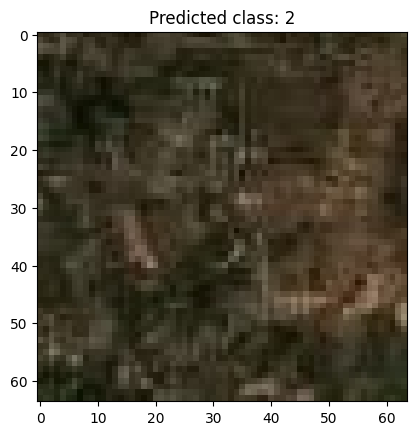

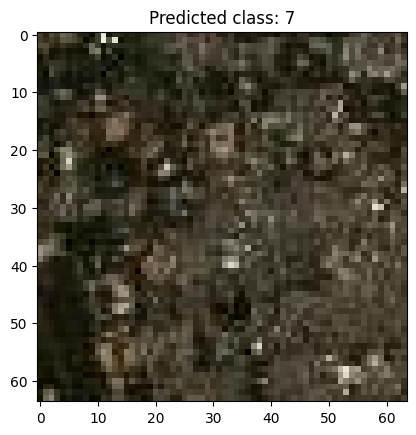

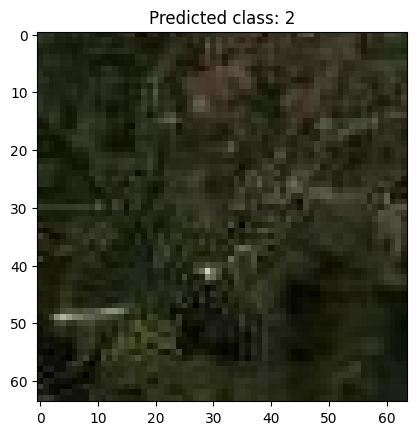

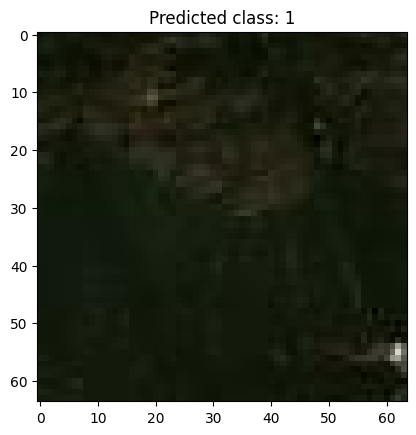

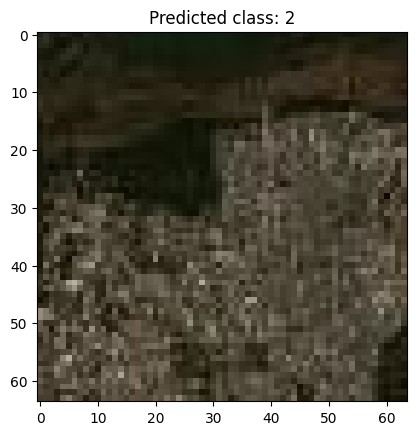

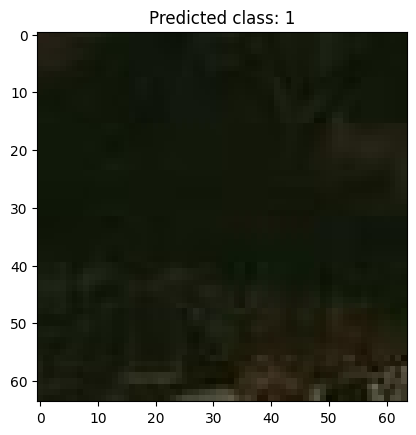

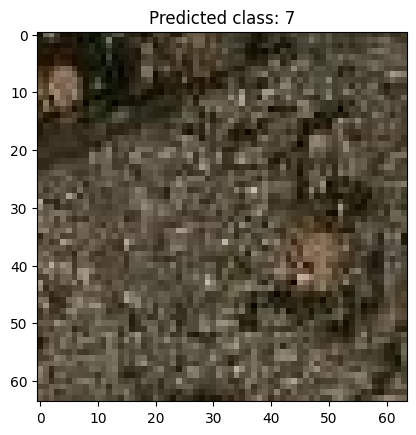

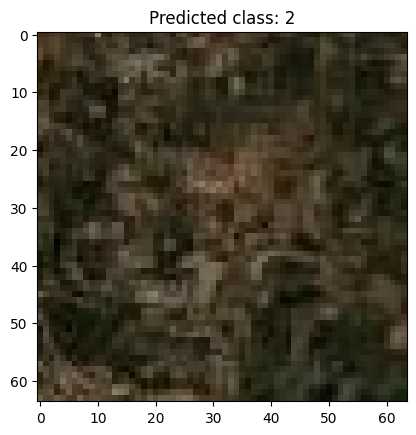

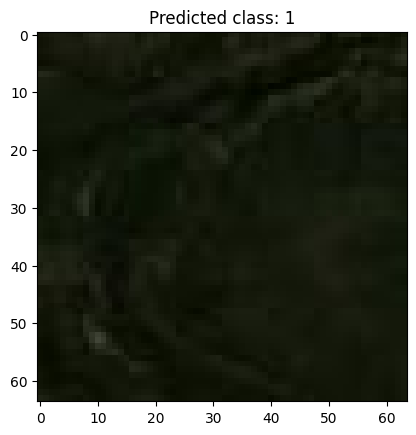

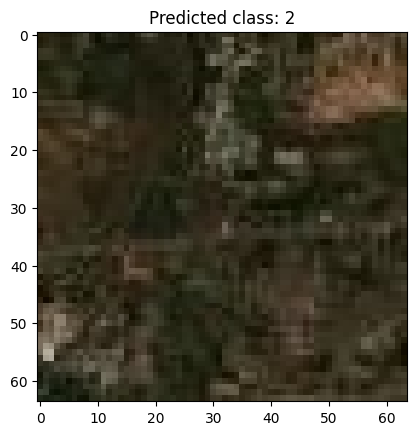

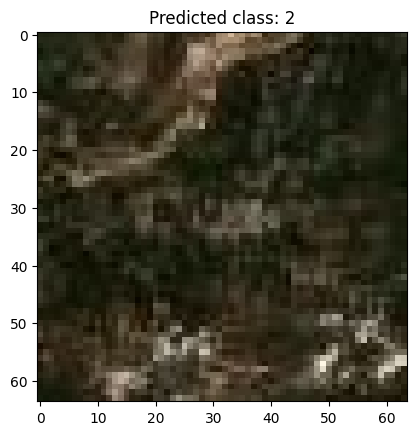

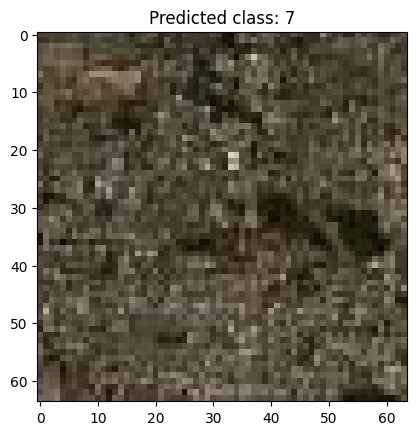

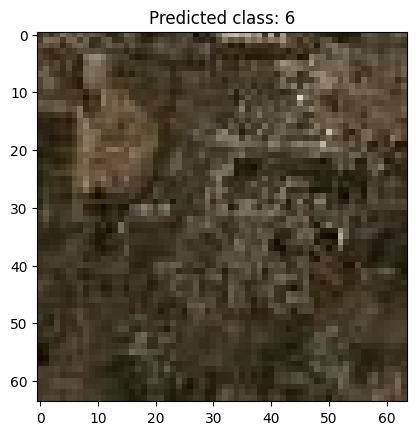

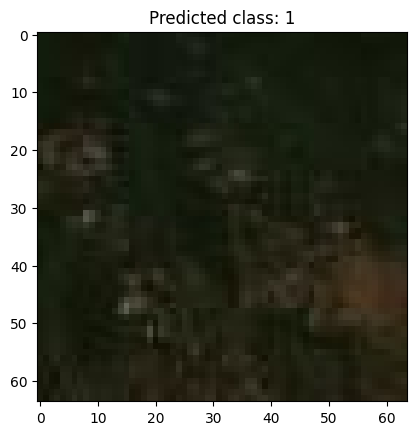

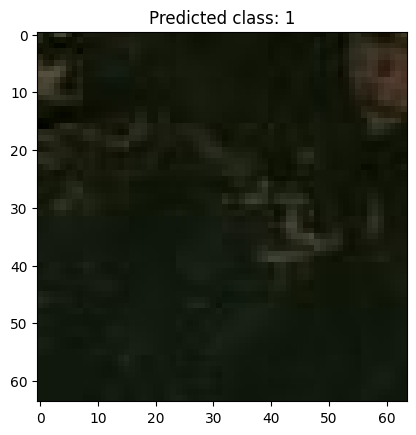

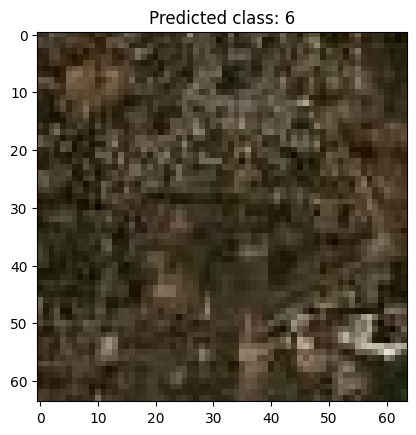

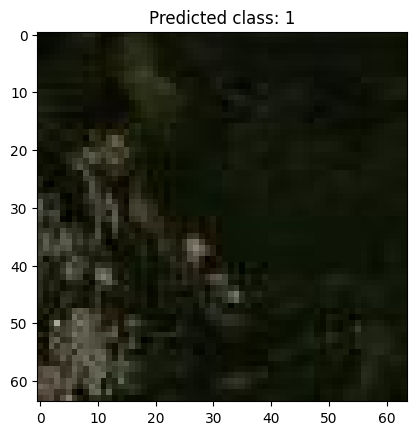

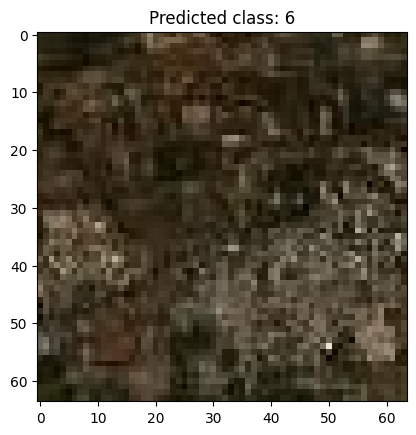

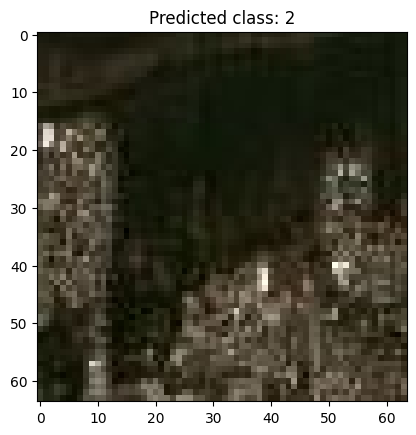

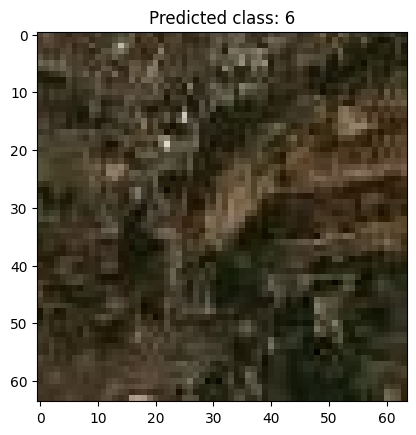

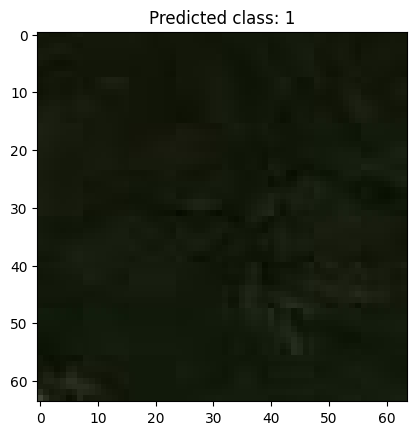

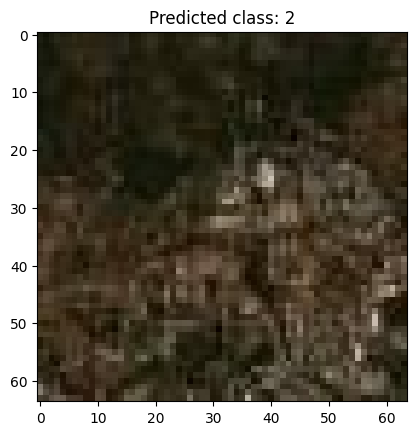

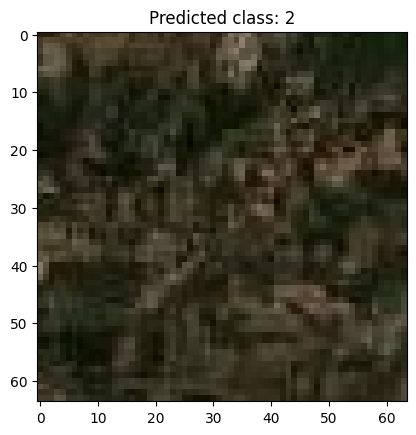

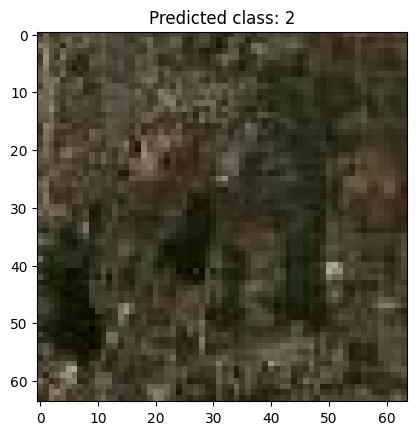

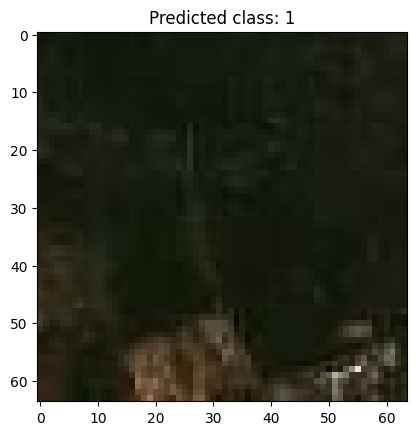

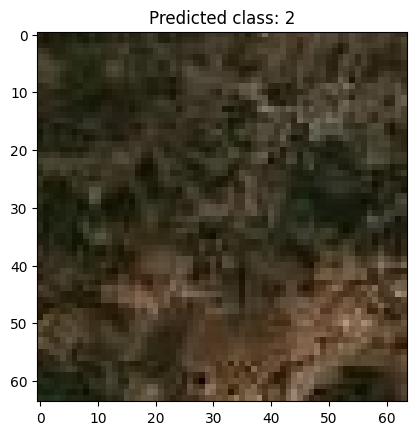

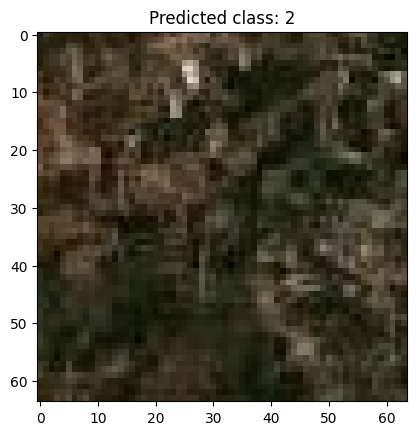

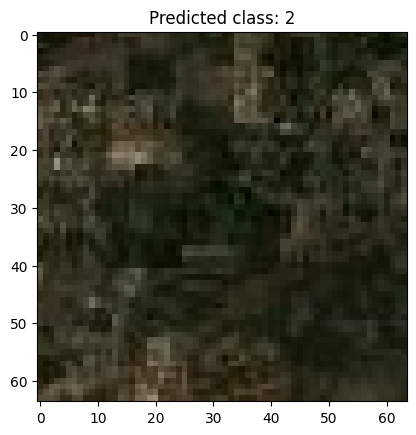

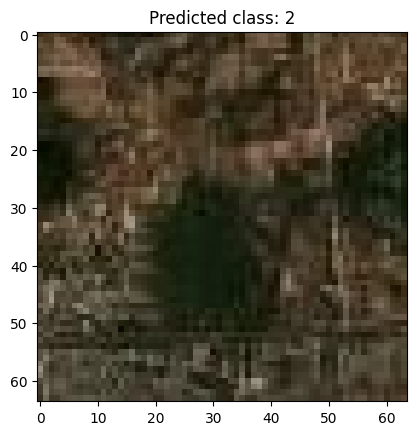

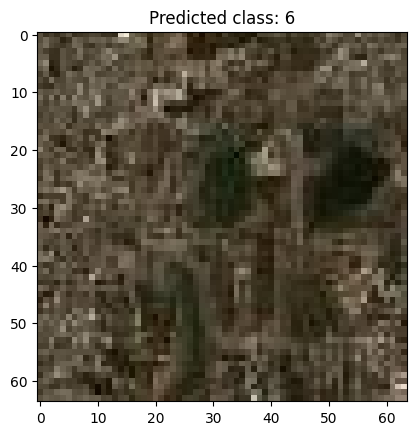

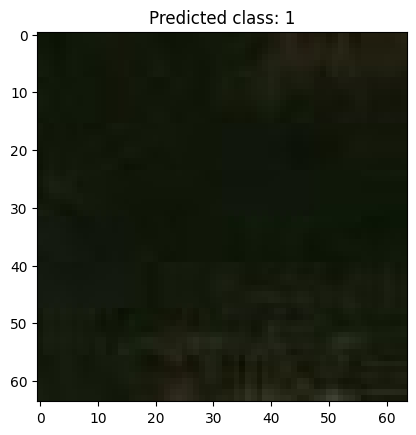

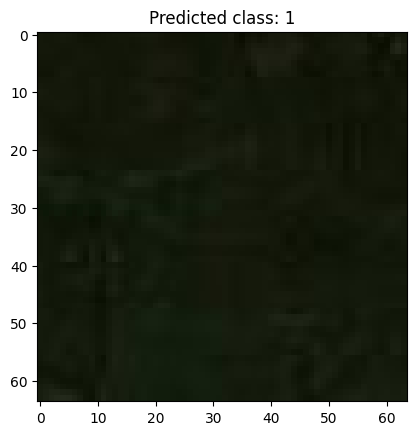

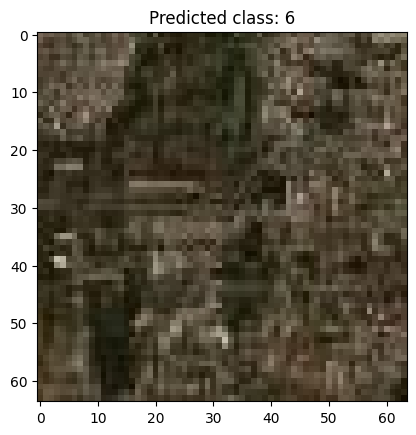

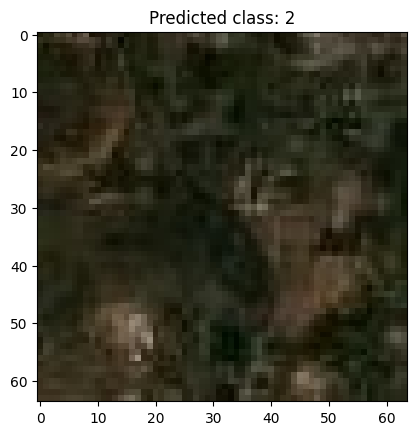

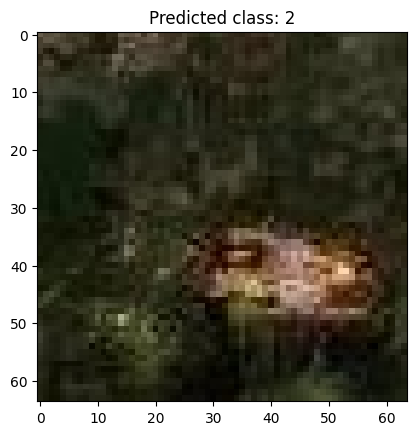

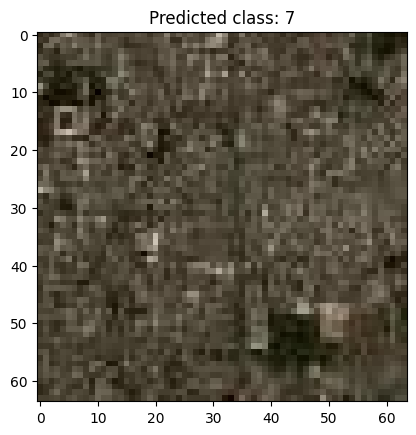

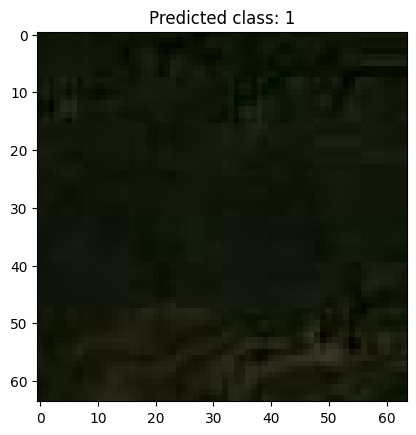

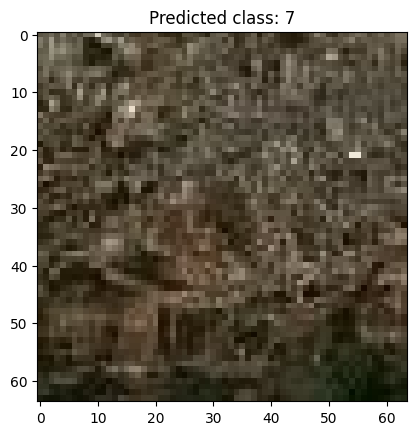

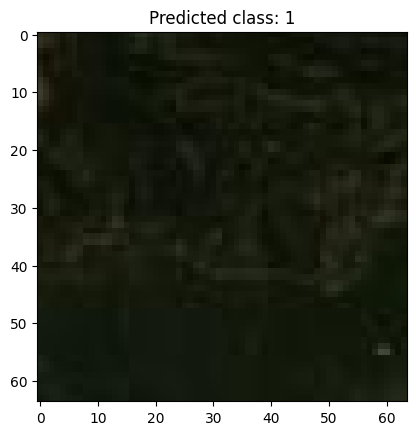

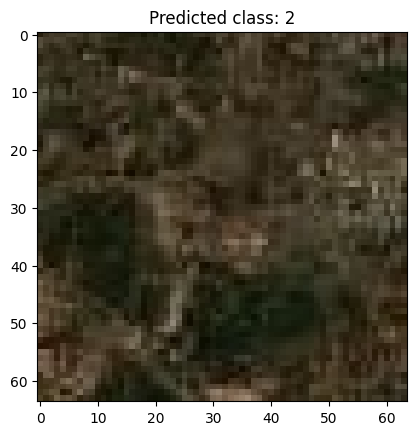

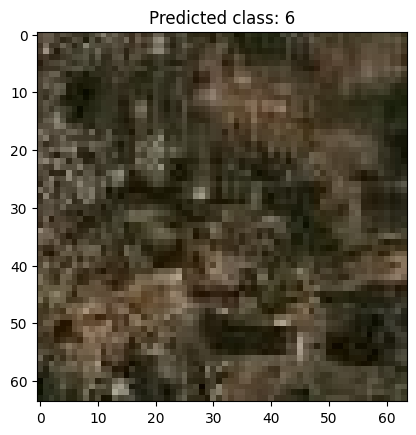

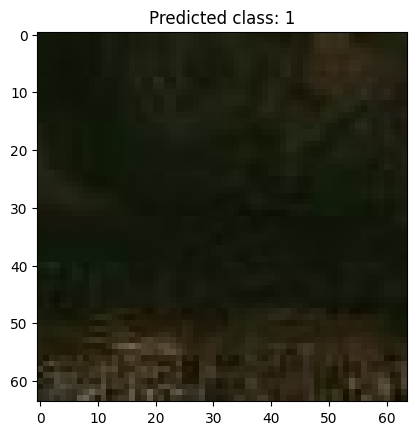

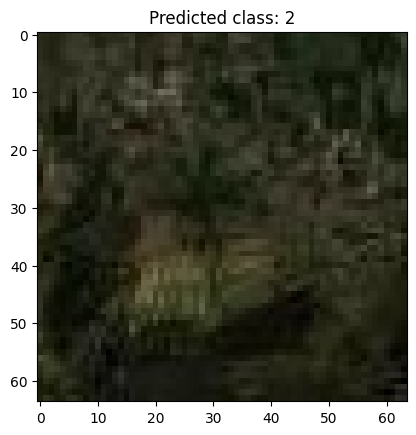

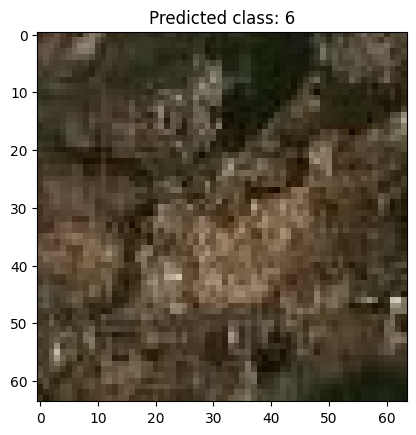

In [27]:
import matplotlib.pyplot as plt

# ...

# Load and preprocess each image in the new_test_image folder
new_test_images = []
image_files = []  # store image file names to use later
for image_file in os.listdir(new_test_image_folder):
    image_path = os.path.join(new_test_image_folder, image_file)
    img = load_and_preprocess_image(image_path)
    new_test_images.append(img)
    image_files.append(image_file)  # save the image file name

new_test_images = np.vstack(new_test_images)  # stack images

# ...

# Predict the classes of the new images
predictions = model.predict(new_test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display each image with its predicted class
for i in range(len(new_test_images)):
    plt.imshow(new_test_images[i])
    plt.title(f'Predicted class: {predicted_classes[i]}')
    plt.show()